### 1. Imports

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import plotly.express as px

#Libraries for preprocessing
from gensim.parsing.preprocessing import remove_stopwords
import string
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import webcolors

#Download once if using NLTK for preprocessing
import nltk
nltk.download('punkt')

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import GridSearchCV

#Libraries for clustering
from sklearn.cluster import KMeans

[nltk_data] Downloading package punkt to /Users/chris/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### 2. Data cleaning

The provided dataset has been corrupted with multiple layers of encoding. <br>
From my investigation result, this dataset has been saved as UTF-8 → misread as Windows-1252 → re-encoded as UTF-8. <br>

I need to solve that first:

#### 2.1. Fix encoding corruption

In [2]:
def fix_encoding_multilayer(text):
    if not isinstance(text, str):
        return text
    
    original = text
    
    # Try multiple passes of different fixes
    try:
        # First pass: UTF-8 → Windows-1252 → UTF-8 (Ã¤ → ä)
        text = text.encode('latin-1').decode('utf-8')
    except (UnicodeDecodeError, UnicodeEncodeError):
        pass
    
    try:
        # Second pass: catch remaining issues
        # Sometimes there are double-corruptions
        text = text.encode('latin-1').decode('utf-8')
    except (UnicodeDecodeError, UnicodeEncodeError):
        pass
    
    # Fix common HTML entities that got corrupted
    replacements = {
        'â€"': "'",      # corrupted apostrophe/single quote
        'â€˜': "'",      # corrupted left single quote
        'â€™': "'",      # corrupted right single quote
        'â€œ': '"',      # corrupted left double quote
        'â€': '"',       # corrupted right double quote
        'â€"': '—',      # em dash
        'â€"': '–',      # en dash
        'Â´': "'",       # corrupted acute accent/apostrophe
        'Â': '',         # corrupted non-breaking space (often appears alone)
        'Ã©': 'é',
        'Ã¨': 'è',
        'Ã«': 'ë',
        'Ã¯': 'ï',
        'Ã´': 'ô',
        'Ã¢': 'â',
        'Ã§': 'ç',
        'Ã ': 'à',
        'Ã¹': 'ù',
        'Ã»': 'û',
        'Ã®': 'î',
        'Ã‰': 'É',
        'Ã‹': 'Ë',
        'Ã': 'Ó',
    }
    
    for corrupted, fixed in replacements.items():
        text = text.replace(corrupted, fixed)
    
    return text

# Read and fix CSV
df = pd.read_csv('view_food.csv', encoding='utf-8')

# Apply fix to all string columns
for col in df.select_dtypes(include=['object']).columns:
    df[col] = df[col].apply(fix_encoding_multilayer)

# Save fixed CSV
df.to_csv('view_food_cleaned.csv', index=False, encoding='utf-8')

/var/folders/1p/gl48js3964n3jh2chpp0xk9c0000gn/T/ipykernel_47516/661422021.py:54: DtypeWarning: Columns (36,52) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('view_food.csv', encoding='utf-8')


In [3]:
text_cols = ['name', 'name_search', 'remarks', 'synonyms', 'brands', 'brands_search', 'bron', 'categories']

In [4]:
df = pd.read_csv("view_food_cleaned.csv")

/var/folders/1p/gl48js3964n3jh2chpp0xk9c0000gn/T/ipykernel_47516/1797570997.py:1: DtypeWarning: Columns (36,52) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("view_food_cleaned.csv")


In [5]:
# Concatenate all text columns into a new column 'all_text', separated by single spaces
df['concat_text'] = (
    df[text_cols]
    .fillna('')                 # replace NaN with empty string
    .astype(str)                # ensure all values are strings
    .agg(' '.join, axis=1)      # join columns with spaces
    .str.replace(r'\s+', ' ', regex=True)  # collapse multiple spaces
    .str.strip()                # trim leading/trailing spaces
)

In [6]:
# normalize concat_text: lowercase, remove commas and digits, collapse whitespace
df['concat_text_2'] = (
    df['concat_text']
    .fillna('')  # avoid NaN issues
    .str.lower()
    .str.replace(r'[,\d]+', '', regex=True)  # remove commas and all numeric characters
    .str.replace(r'\s+', ' ', regex=True)    # collapse multiple spaces
    .str.strip()
)

In [7]:
import unicodedata
import re

# remove duplicate words within each cell of concat_text_2, preserving first occurrence order

def _dedupe_words(text):
    if not isinstance(text, str):
        return text
    tokens = text.split()  # split on any whitespace
    seen = set()
    out = []
    for t in tokens:
        # normalize to ASCII (remove accents), lowercase and strip non-alphanumerics for comparison
        key = unicodedata.normalize('NFKD', t)
        key = key.encode('ascii', 'ignore').decode('ascii')
        key = key.lower()
        key = re.sub(r'[^a-z0-9]+', '', key)
        # fallback if normalization removed everything
        if not key:
            key = t.lower()
        if key not in seen:
            seen.add(key)
            out.append(t)
    return ' '.join(out)

df['concat_text_3'] = df['concat_text_2'].astype(str).apply(_dedupe_words)

In [8]:
import re

def remove_specific_chars_keep_spaces(s: str) -> str:
    if not isinstance(s, str):
        return s
    # Replace listed characters with a single space, then collapse whitespace
    s = re.sub(r"[()=&%+\;/.\u00B0-]+", " ", s)
    s = re.sub(r"(?:'n|’n)\b", " ", s)
    s = re.sub(r'\s+', ' ', s).strip()
    return s

# Apply to the main concatenated text and create a new column
df['concat_text_4'] = df['concat_text_3'].astype(str).apply(remove_specific_chars_keep_spaces)

In [9]:
from gensim.parsing.preprocessing import remove_stopwords
import string
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import webcolors

#Download once if using NLTK for preprocessing
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /Users/chris/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [10]:
#Stem the sentence (apples and apple become appl)
def stemSentence(sentence):
    porter = PorterStemmer()
    token_words = word_tokenize(sentence)
    stem_sentence = [porter.stem(word) for word in token_words]
    return ' '.join(stem_sentence)

df['concat_text_5'] = pd.Series([stemSentence(x) for x in df['concat_text_4']])
df['concat_text_5'] = df['concat_text_5'].astype(str).apply(_dedupe_words)

In [11]:
import re

# small list of common Dutch conjunctions/prepositions/articles to remove
_dutch_stopwords = {
    "met", "en", "in", "van", "op", "voor", "bij", "uit", "door",
    "naar", "om", "te", "de", "het", "een", "als", "maar", "of",
    "ook", "dan", "tot", "over"
}

_stopwords_pattern = re.compile(r"\b(?:" + "|".join(re.escape(w) for w in _dutch_stopwords) + r")\b", flags=re.IGNORECASE)

def remove_possessive_and_dutch_common(s: str) -> str:
    if not isinstance(s, str):
        return s
    # Remove English/apostrophe possessive forms and typographic variants
    s = s.replace("'s", " ").replace("’s", " ")
    # Also remove isolated trailing apostrophe if any
    s = re.sub(r"['’]\b", " ", s)
    # Remove common Dutch stopwords (as whole words)
    s = _stopwords_pattern.sub(" ", s)
    # Collapse whitespace and strip
    s = re.sub(r"\s+", " ", s).strip()
    # Remove duplicate tokens while preserving order (reuse existing helper)
    return _dedupe_words(s)

# Apply to the stemmed/cleaned text column and create a new column
df['concat_text_6'] = df['concat_text_5'].astype(str).apply(remove_possessive_and_dutch_common)

In [12]:
def remove_one_letter_words(text):
    if not isinstance(text, str):
        return text
    tokens = text.split()
    tokens = [t for t in tokens if len(t) > 1]
    return ' '.join(tokens)

# Apply to the latest cleaned column and produce a new column without one-letter words.
df['concat_text_7'] = df['concat_text_6'].astype(str).apply(remove_one_letter_words).apply(_dedupe_words)

### 3. Vectorization

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.cluster import DBSCAN
from sklearn.feature_extraction.text import CountVectorizer
from matplotlib import pyplot as plt
from sklearn.decomposition import TruncatedSVD

In [14]:
tfidf_vectorizer = TfidfVectorizer(use_idf=True)
tfidf_vectors = tfidf_vectorizer.fit_transform(df['concat_text_7'])

In [15]:
dbscan = DBSCAN(eps=0.3, min_samples=3, metric='cosine') # Using cosine distance for better text vector comparison

# Fit DBSCAN on the TF-IDF matrix (one row per product) and save labels to product_text
labels = dbscan.fit_predict(tfidf_vectors)
df['cluster_id'] = labels

n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
nonly_noise = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters)
print("Estimated number of noise points: %d" % nonly_noise)

Estimated number of clusters: 759
Estimated number of noise points: 12415


In [16]:
df[['id', 'name', 'active', 'cluster_id']]

,id,name,active,cluster_id
0,24615,Dolce Gusto Lungo,1,0
1,24616,Dolce Gusto espresso intenso,1,0
2,24617,Dolce Gusto grande intenso,1,0
3,24618,Dolce Gusto cappuccino,1,0
4,24619,Dolce Gusto cappuccino ice,1,0
...,...,...,...,...
17910,45480,Maiswafels Met Pizzasmaak En Kruiden,1,-1
17911,45481,Proteïne meerzadenbrood,1,-1
17912,45482,Veggie sea salade,0,-1
17913,45483,Naam niet gevonden,0,621


In [17]:
def plot_dbscan_svd(tfidf_matrix,
                    labels=labels,
                    dbscan_model=dbscan,
                    n_components=2,
                    figsize=(10, 6),
                    marker_core_size=50,
                    marker_border_size=8,
                    show_legend=False,
                    title=None):
    """
    Reduce TF-IDF matrix to 2D with TruncatedSVD and plot DBSCAN clusters.
    Returns: coords_2d, svd, fig, ax
    Defaults use variables already defined in the notebook.
    """
    svd = TruncatedSVD(n_components=n_components, random_state=42)
    coords_2d = svd.fit_transform(tfidf_matrix)

    unique_labels = sorted(set(labels))
    core_samples_mask = np.zeros_like(labels, dtype=bool)
    core_idx = getattr(dbscan_model, "core_sample_indices_", None)
    if core_idx is not None:
        core_samples_mask[core_idx] = True

    fig, ax = plt.subplots(figsize=figsize)
    colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

    for k, col in zip(unique_labels, colors):
        if k == -1:
            col = (0, 0, 0, 1)  # black for noise

        class_member_mask = labels == k
        mask_core = class_member_mask & core_samples_mask
        mask_border = class_member_mask & ~core_samples_mask

        xy_core = coords_2d[mask_core]
        if xy_core.size:
            ax.scatter(xy_core[:, 0], xy_core[:, 1],
                       facecolor=tuple(col), edgecolor="k",
                       s=marker_core_size, marker="o",
                       label=f"cluster {k}" if k != -1 else "noise")

        xy_border = coords_2d[mask_border]
        if xy_border.size:
            ax.scatter(xy_border[:, 0], xy_border[:, 1],
                       facecolor=tuple(col), edgecolor="k",
                       s=marker_border_size, marker="o")

    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    if title is None:
        title = f"Estimated number of clusters: {n_clusters}"
    ax.set_title(title)

    if show_legend:
        ax.legend(loc="best", markerscale=1, fontsize="small", ncol=2)

    plt.show()
    return coords_2d, svd, fig, ax

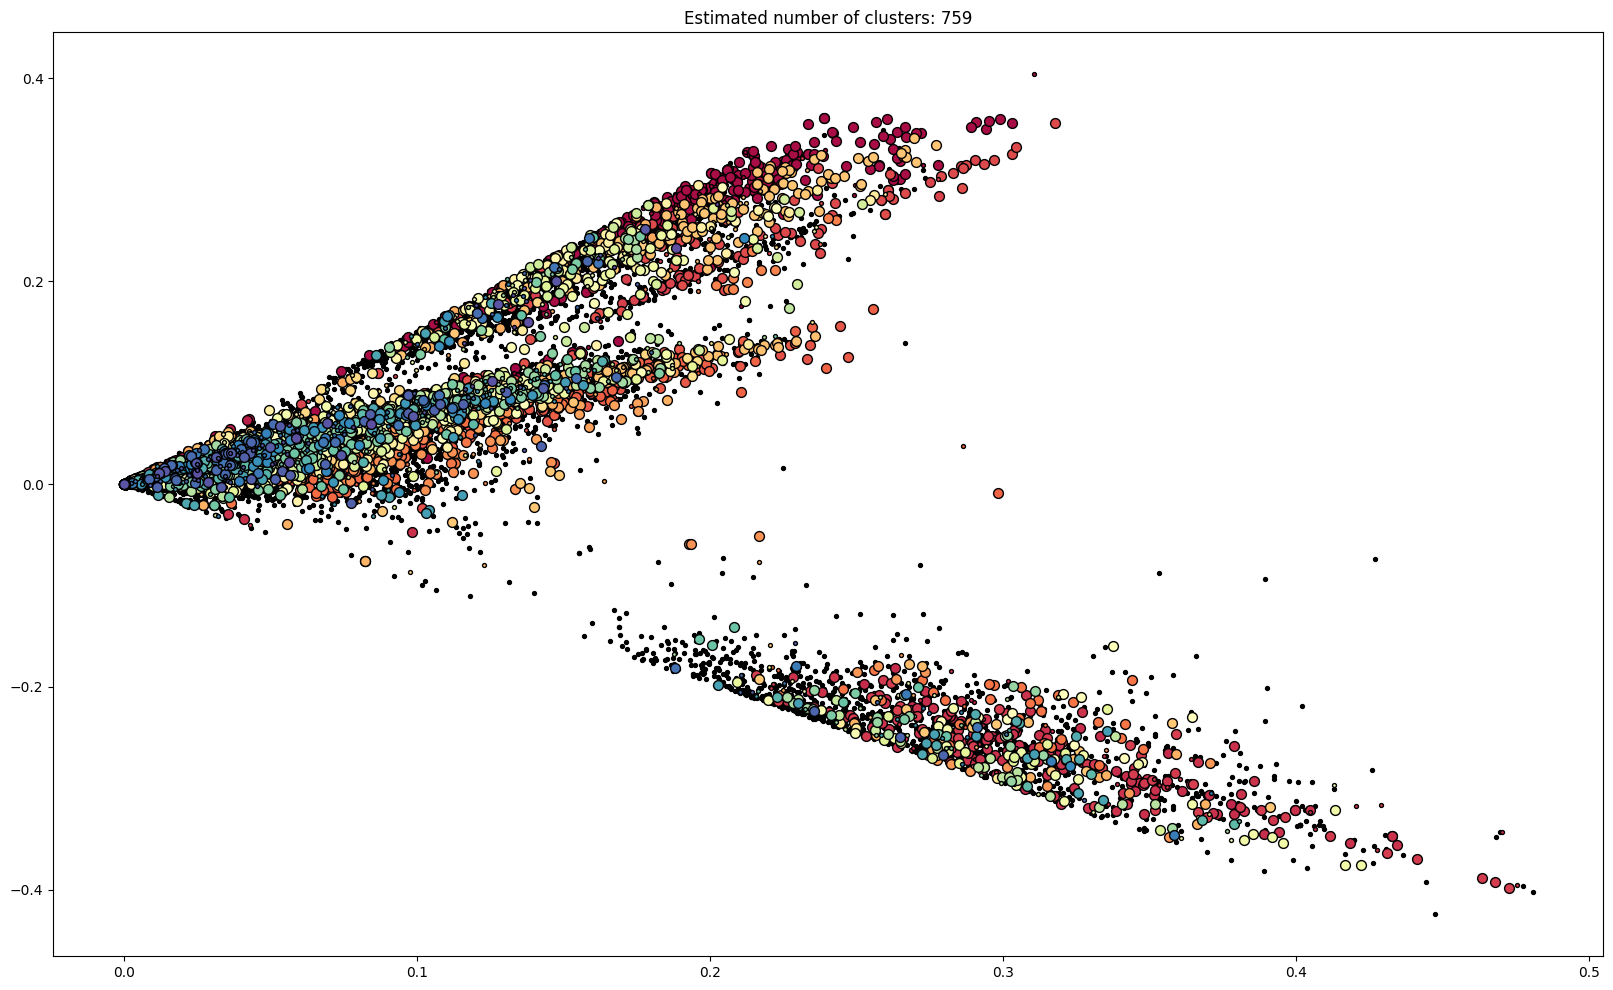

(array([[ 0.00748189,  0.00533474],
        [ 0.00669111,  0.00477827],
        [ 0.00742352,  0.00541555],
        ...,
        [ 0.016512  , -0.00741093],
        [ 0.00175169,  0.00107157],
        [ 0.0055016 ,  0.00391274]]),
 TruncatedSVD(random_state=42),
 <Figure size 2000x1200 with 1 Axes>,
 <Axes: title={'center': 'Estimated number of clusters: 759'}>)

In [18]:

import numpy as np
plot_dbscan_svd(tfidf_vectors,
                labels,
                dbscan,
                2,
                (20, 12),
                50,
                8,
                False,
                None
)

In [19]:
df.columns

Index(['id', 'name', 'name_search', 'active', 'energy', 'protein', 'fat',
       'saturated_fatty_acid', 'carbohydrates', 'sugar', 'starch',
       'dietary_fiber', 'salt', 'sodium', 'k', 'ca', 'p', 'fe', 'polyols',
       'remarks', 'cholesterol', 'omega6', 'omega3', 'mov', 'eov', 'vit_d',
       'vit_c', 'vit_b12', 'vit_b6', 'vit_b2', 'vit_b1', 'vit_a', 'mg',
       'water', 'is_food', 'remarks_carbohydrates', 'hash', 'user_study_id',
       'unit', 'synonyms', 'brands', 'brands_search', 'glucose', 'fructose',
       'excess_fructose', 'lactose', 'sorbitol', 'mannitol', 'fructans', 'gos',
       'token', 'token_deleted', 'bron', 'user_id', 'deleted', 'categories',
       'barcode', 'merged_to', 'created', 'updated', 'app_ver', 'concat_text',
       'concat_text_2', 'concat_text_3', 'concat_text_4', 'concat_text_5',
       'concat_text_6', 'concat_text_7', 'cluster_id'],
      dtype='object')

In [21]:
df_clustered = df[['id', 'name', 'name_search', 'active', 'energy', 'protein', 'fat',
       'saturated_fatty_acid', 'carbohydrates', 'sugar', 'starch',
       'dietary_fiber', 'salt', 'sodium', 'k', 'ca', 'p', 'fe', 'polyols',
       'remarks', 'cholesterol', 'omega6', 'omega3', 'mov', 'eov', 'vit_d',
       'vit_c', 'vit_b12', 'vit_b6', 'vit_b2', 'vit_b1', 'vit_a', 'mg',
       'water', 'is_food', 'remarks_carbohydrates', 'hash', 'user_study_id',
       'unit', 'synonyms', 'brands', 'brands_search', 'glucose', 'fructose',
       'excess_fructose', 'lactose', 'sorbitol', 'mannitol', 'fructans', 'gos',
       'token', 'token_deleted', 'bron', 'user_id', 'deleted', 'categories',
       'barcode', 'merged_to', 'created', 'updated', 'app_ver', 'cluster_id']]

df_clustered.to_csv("view_food_clustered.csv", index=False)

In [ ]:
df_clustered

,id,name,name_search,active,energy,protein,fat,saturated_fatty_acid,carbohydrates,sugar,...,bron,user_id,deleted,categories,barcode,merged_to,created,updated,app_ver,cluster_id
0,24615,Dolce Gusto Lungo,dolce gusto lungo,1,0.0,0.0,0.0,0.0,0.0,0.0,...,Nescafé,NaN,NaN,dranken,7613031794331;5400113609087;8445290872203,NaN,2023-01-01 00:00:00,2024-12-12 16:40:08,NaN,0
1,24616,Dolce Gusto espresso intenso,dolce gusto espresso intenso,1,0.0,0.0,0.0,0.0,0.0,0.0,...,Nescafé,NaN,NaN,dranken,7613036828444,NaN,2023-01-01 00:00:00,2024-12-12 16:40:08,NaN,0
2,24617,Dolce Gusto grande intenso,dolce gusto grande intenso,1,0.0,0.0,0.0,0.0,0.0,0.0,...,Nescafé,NaN,NaN,dranken,NaN,NaN,2023-01-01 00:00:00,2024-12-12 16:40:08,NaN,0
3,24618,Dolce Gusto cappuccino,dolce gusto cappuccino,1,36.0,1.6,1.6,1.0,3.5,3.5,...,Nescafé,NaN,NaN,dranken,7613036306294;7613036303477,NaN,2023-01-01 00:00:00,2025-03-12 11:52:28,NaN,0
4,24619,Dolce Gusto cappuccino ice,dolce gusto cappuccino ice,1,48.0,1.8,1.2,0.8,7.3,6.8,...,Nescafé,NaN,NaN,dranken,NaN,NaN,2023-01-01 00:00:00,2024-12-12 16:40:08,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17910,45480,Maiswafels Met Pizzasmaak En Kruiden,maiswafels met pizzasmaak en kruiden,1,415.0,7.4,8.7,0.8,75.0,2.8,...,NaN,NaN,NaN,NaN,8718907850094,NaN,2025-09-27 22:56:05,2025-09-27 23:00:15,1.3.1,-1
17911,45481,Proteïne meerzadenbrood,proteine meerzadenbrood,1,270.0,21.3,13.1,1.5,10.3,1.4,...,NaN,NaN,NaN,aardappelen en graanproducten,5410724425211;05410724425112,NaN,2025-09-27 23:11:03,2025-09-27 23:15:13,1.3.1,-1
17912,45482,Veggie sea salade,veggie sea salade,0,318.0,5.0,32.0,2.5,2.3,1.2,...,NaN,NaN,NaN,NaN,5413345008504,NaN,2025-09-28 09:48:11,2025-09-28 09:48:11,1.3.1,-1
17913,45483,Naam niet gevonden,naam niet gevonden,0,0.0,0.0,0.0,0.0,0.0,NaN,...,NaN,NaN,NaN,NaN,5715008111133,NaN,2025-09-28 19:43:28,2025-09-28 19:43:28,1.3.1,621


In [ ]:
# Remove specified ids from df_clustered
ids_to_remove = [42165, 41132, 42155, 41280, 26568]

before_count = df_clustered.shape[0]
df_clustered = df_clustered[~df_clustered['id'].isin(ids_to_remove)].reset_index(drop=True)
after_count = df_clustered.shape[0]

print(f"Removed {before_count - after_count} rows. New shape: {df_clustered.shape}")

Removed 5 rows. New shape: (17910, 62)


In [ ]:
df_clustered

,id,name,name_search,active,energy,protein,fat,saturated_fatty_acid,carbohydrates,sugar,...,bron,user_id,deleted,categories,barcode,merged_to,created,updated,app_ver,cluster_id
0,24615,Dolce Gusto Lungo,dolce gusto lungo,1,0.0,0.0,0.0,0.0,0.0,0.0,...,Nescafé,NaN,NaN,dranken,7613031794331;5400113609087;8445290872203,NaN,2023-01-01 00:00:00,2024-12-12 16:40:08,NaN,0
1,24616,Dolce Gusto espresso intenso,dolce gusto espresso intenso,1,0.0,0.0,0.0,0.0,0.0,0.0,...,Nescafé,NaN,NaN,dranken,7613036828444,NaN,2023-01-01 00:00:00,2024-12-12 16:40:08,NaN,0
2,24617,Dolce Gusto grande intenso,dolce gusto grande intenso,1,0.0,0.0,0.0,0.0,0.0,0.0,...,Nescafé,NaN,NaN,dranken,NaN,NaN,2023-01-01 00:00:00,2024-12-12 16:40:08,NaN,0
3,24618,Dolce Gusto cappuccino,dolce gusto cappuccino,1,36.0,1.6,1.6,1.0,3.5,3.5,...,Nescafé,NaN,NaN,dranken,7613036306294;7613036303477,NaN,2023-01-01 00:00:00,2025-03-12 11:52:28,NaN,0
4,24619,Dolce Gusto cappuccino ice,dolce gusto cappuccino ice,1,48.0,1.8,1.2,0.8,7.3,6.8,...,Nescafé,NaN,NaN,dranken,NaN,NaN,2023-01-01 00:00:00,2024-12-12 16:40:08,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17905,45480,Maiswafels Met Pizzasmaak En Kruiden,maiswafels met pizzasmaak en kruiden,1,415.0,7.4,8.7,0.8,75.0,2.8,...,NaN,NaN,NaN,NaN,8718907850094,NaN,2025-09-27 22:56:05,2025-09-27 23:00:15,1.3.1,-1
17906,45481,Proteïne meerzadenbrood,proteine meerzadenbrood,1,270.0,21.3,13.1,1.5,10.3,1.4,...,NaN,NaN,NaN,aardappelen en graanproducten,5410724425211;05410724425112,NaN,2025-09-27 23:11:03,2025-09-27 23:15:13,1.3.1,-1
17907,45482,Veggie sea salade,veggie sea salade,0,318.0,5.0,32.0,2.5,2.3,1.2,...,NaN,NaN,NaN,NaN,5413345008504,NaN,2025-09-28 09:48:11,2025-09-28 09:48:11,1.3.1,-1
17908,45483,Naam niet gevonden,naam niet gevonden,0,0.0,0.0,0.0,0.0,0.0,NaN,...,NaN,NaN,NaN,NaN,5715008111133,NaN,2025-09-28 19:43:28,2025-09-28 19:43:28,1.3.1,621


In [ ]:
df_clustered.to_csv("view_food_clustered.csv", index=False)

### 4. Create a table

In [ ]:
-- Create table with same columns as df_clustered (PostgreSQL)
CREATE TABLE IF NOT EXISTS product (
    id BIGINT PRIMARY KEY,
    name TEXT,
    name_search TEXT,
    active INTEGER,
    energy DOUBLE PRECISION,
    protein DOUBLE PRECISION,
    fat DOUBLE PRECISION,
    saturated_fatty_acid DOUBLE PRECISION,
    carbohydrates DOUBLE PRECISION,
    sugar DOUBLE PRECISION,
    starch DOUBLE PRECISION,
    dietary_fiber DOUBLE PRECISION,
    salt DOUBLE PRECISION,
    sodium DOUBLE PRECISION,
    k DOUBLE PRECISION,
    ca DOUBLE PRECISION,
    p DOUBLE PRECISION,
    fe DOUBLE PRECISION,
    polyols DOUBLE PRECISION,
    remarks TEXT,
    cholesterol DOUBLE PRECISION,
    omega6 DOUBLE PRECISION,
    omega3 DOUBLE PRECISION,
    mov DOUBLE PRECISION,
    eov DOUBLE PRECISION,
    vit_d DOUBLE PRECISION,
    vit_c DOUBLE PRECISION,
    vit_b12 DOUBLE PRECISION,
    vit_b6 DOUBLE PRECISION,
    vit_b2 DOUBLE PRECISION,
    vit_b1 DOUBLE PRECISION,
    vit_a DOUBLE PRECISION,
    mg DOUBLE PRECISION,
    water DOUBLE PRECISION,
    is_food INTEGER,
    remarks_carbohydrates DOUBLE PRECISION,
    hash TEXT,
    user_study_id DOUBLE PRECISION,
    unit TEXT,
    synonyms TEXT,
    brands TEXT,
    brands_search TEXT,
    glucose DOUBLE PRECISION,
    fructose DOUBLE PRECISION,
    excess_fructose DOUBLE PRECISION,
    lactose DOUBLE PRECISION,
    sorbitol DOUBLE PRECISION,
    mannitol DOUBLE PRECISION,
    fructans DOUBLE PRECISION,
    gos DOUBLE PRECISION,
    token TEXT,
    token_deleted TEXT,
    bron TEXT,
    user_id DOUBLE PRECISION,
    deleted TEXT,
    categories TEXT,
    barcode TEXT,
    merged_to TEXT,
    created TIMESTAMP,
    updated TIMESTAMP,
    app_ver TEXT,
    cluster_id INTEGER
);

-- Optional: index on cluster_id for faster cluster lookups
CREATE INDEX IF NOT EXISTS idx_product_cluster_id ON product(cluster_id);

##### 4.1. Add the exported CSV to the database (with cluster_id)

##### 4.2. Update cluster count

```SQL
UPDATE product t1
SET cluster_count = CASE 
    WHEN t1.cluster_id = -1 THEN 1 
    ELSE t2.cnt 
END
FROM (
    SELECT cluster_id, COUNT(*) as cnt 
    FROM product 
    GROUP BY cluster_id
) t2
WHERE t1.cluster_id = t2.cluster_id;
```